# Rare subword corpus evaluation

In [4]:
from datasets import load_dataset
from transformers import AutoTokenizer
from hydra import compose, initialize
from hydra.core.config_store import ConfigStore
import matplotlib.pyplot as plt

import sys
sys.path.append('../')

from src.utils.data import DatasetPreprocessor, POSLookup
from src.utils.data import POS_TAG_MAP
from src.config import BabyLMConfig

initialize(version_base=None, config_path="../conf")
compose(overrides=["+db=mysql"])

cs = ConfigStore.instance()
cs.store(name="base_config", node=BabyLMConfig)

In [5]:
TOKENIZER = 'CamBabyTrainers/CamBabyTokenizer-8192'
#TOKENIZER='babylm/opt-125m-strict-small'
#TOKENIZER='babylm/roberta-base-strict-small'
#TOKENIZER='babylm/t5-base-strict-small'
DATASET = 'CamBabyTrainers/BabyLM'
DATASET_SPLIT = 'train'
DATASET_SUBSET = 'original_strict_small_gold'

POS_TAG_MAP_REVERSE = {v: k for k, v in POS_TAG_MAP.items()}

In [6]:
tokenizer = AutoTokenizer.from_pretrained(TOKENIZER)
dataset = load_dataset(DATASET, DATASET_SUBSET, split=DATASET_SPLIT)

tokenizer_config.json: 100%|██████████| 573/573 [00:00<00:00, 361kB/s]
vocab.json: 100%|██████████| 116k/116k [00:00<00:00, 1.42MB/s]
merges.txt: 100%|██████████| 66.7k/66.7k [00:00<00:00, 1.00MB/s]
tokenizer.json: 100%|██████████| 321k/321k [00:00<00:00, 1.90MB/s]
Extracting data files: 100%|██████████| 3/3 [00:00<00:00, 118.15it/s]
Generating train split: 1015485 examples [00:17, 59030.80 examples/s]
Generating validation split: 985958 examples [00:17, 57899.06 examples/s]
Generating test split: 1008786 examples [00:17, 57611.70 examples/s]


In [7]:
conf=compose(config_name="config.yaml")
conf.data_preprocessing.include_punctuation = True
conf.data_preprocessing.max_input_length = 128
conf.data_preprocessing.join_sentences = False
conf.dataset.subconfig = DATASET_SUBSET

data_preprocessor = DatasetPreprocessor(conf, tokenizer)

processed_dataset = dataset.map(
    data_preprocessor,
    batched=True,
    num_proc=64,
    remove_columns=dataset.column_names,
)

pos_lookup = POSLookup(processed_dataset, tokenizer)

Map (num_proc=64): 100%|██████████| 1015485/1015485 [00:23<00:00, 44089.92 examples/s]
/Users/zebulongoriely/Documents/UniDocs/PHD/research/projects/pos-merge/env/lib/python3.9/site-packages/datasets/table.py:1421: FutureWarning: promote has been superseded by mode='default'.
  table = cls._concat_blocks(blocks, axis=0)
/Users/zebulongoriely/Documents/UniDocs/PHD/research/projects/pos-merge/env/lib/python3.9/site-packages/datasets/table.py:1387: FutureWarning: promote has been superseded by mode='default'.
  return cls._concat_blocks(pa_tables_to_concat_vertically, axis=0)
/Users/zebulongoriely/Documents/UniDocs/PHD/research/projects/pos-merge/env/lib/python3.9/site-packages/datasets/table.py:1387: FutureWarning: promote has been superseded by mode='default'.
  return cls._concat_blocks(pa_tables_to_concat_vertically, axis=0)
/Users/zebulongoriely/Documents/UniDocs/PHD/research/projects/pos-merge/env/lib/python3.9/site-packages/datasets/table.py:1387: FutureWarning: promote has been su

In [8]:
token_counts = pos_lookup.lookup_matrix.sum(axis=1)
special_ids = tokenizer.all_special_ids

# Create pairs of (token, count) and sort by count
sorted_tokens = list(enumerate(token_counts))
sorted_tokens.sort(key=lambda x: x[1], reverse=True)
sorted_tokens = [(i, count.item()) for i, count in sorted_tokens if i not in special_ids and count > 0]

In [9]:
# Average count of top 100 tokens
print('Average of top 100 tokens:', sum([token[1] for token in sorted_tokens[:100]]) / 100)
# Average count of bottom 100 tokens
print('Average of bottom 100 tokens:', sum([token[1] for token in sorted_tokens[-100:]]) / 100)

# Average count of middle 100 tokens
middle = len(sorted_tokens) // 2
print('Average of middle 100 tokens:', sum([token[1] for token in sorted_tokens[middle-50:middle+50]]) / 100)

# 50th percentile, 90th percentile and 99th percentile
sum_of_counts = sum([token[1] for token in sorted_tokens])
cumulative_sum = 0
for i,token in enumerate(sorted_tokens):
    cumulative_sum += token[1]
    if cumulative_sum >= sum_of_counts / 2:
        print('50th percentile:', i)
        break
cumulative_sum = 0
for i,token in enumerate(sorted_tokens):
    cumulative_sum += token[1]
    if cumulative_sum >= sum_of_counts * 0.9:
        print('90th percentile:', i)
        break
cumulative_sum = 0
for i,token in enumerate(sorted_tokens):
    cumulative_sum += token[1]
    if cumulative_sum >= sum_of_counts * 0.99:
        print('99th percentile:', i)
        break
    

Average of top 100 tokens: 69705.55
Average of bottom 100 tokens: 7.33
Average of middle 100 tokens: 378.7
50th percentile: 108
90th percentile: 2957
99th percentile: 6918


/var/folders/nz/6tzh0bsj2txd1cz18gpcms_c0000gn/T/ipykernel_88431/1743358310.py:9: RuntimeWarning: divide by zero encountered in divide
  return a / np.power(x, b)
/var/folders/nz/6tzh0bsj2txd1cz18gpcms_c0000gn/T/ipykernel_88431/1743358310.py:9: RuntimeWarning: overflow encountered in divide
  return a / np.power(x, b)


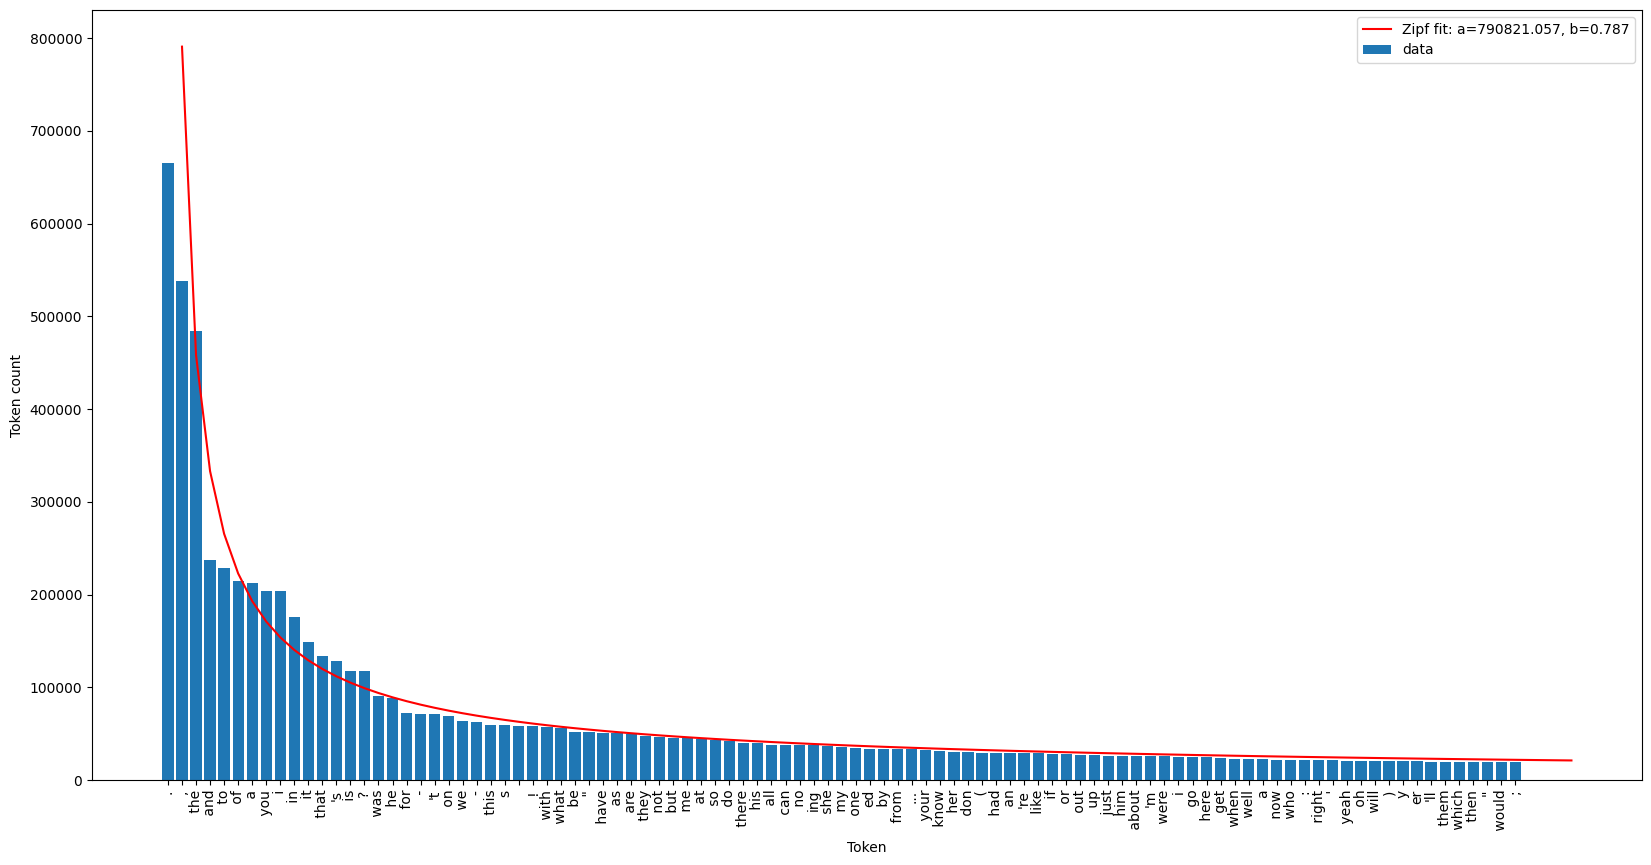

In [10]:
# Fit a Zipfian distribution to the token counts
from scipy.optimize import curve_fit
import numpy as np

CUTOFF = 100
LOG = False

def zipf(x, a, b):
    return a / np.power(x, b)

xdata = np.arange(1, len(sorted_tokens) + 1)
ydata = np.array([token[1] for token in sorted_tokens])

popt, pcov = curve_fit(zipf, xdata, ydata)

# Plot the token counts and the fitted Zipfian distribution
plt.figure(figsize=(20, 10))
#plt.plot(xdata[:100], ydata[:100], 'b-', label='data')
plt.bar([tokenizer.decode([token]) for token, count in sorted_tokens[:CUTOFF]], [count for token, count in sorted_tokens[:CUTOFF]], label='data')
plt.plot(xdata[:CUTOFF], zipf(xdata[:CUTOFF], *popt), 'r-', label='Zipf fit: a=%5.3f, b=%5.3f' % tuple(popt))
plt.xlabel('Token')
plt.xticks(rotation=90)
plt.ylabel('Token count')
plt.legend()
plt.yscale('log' if LOG else 'linear')
plt.show()



In [11]:
# For the top 100 and bottom 100 tokens, get the distribution of part-of-speech tags across the whole dataset
pos_counts_top = pos_lookup.lookup_matrix[[a[0] for a in sorted_tokens[:100]]].sum(axis=0) / pos_lookup.lookup_matrix[[a[0] for a in sorted_tokens[:100]]].sum()
pos_counts_bottom = pos_lookup.lookup_matrix[[a[0] for a in sorted_tokens[-100:]]].sum(axis=0) / pos_lookup.lookup_matrix[[a[0] for a in sorted_tokens[-100:]]].sum()

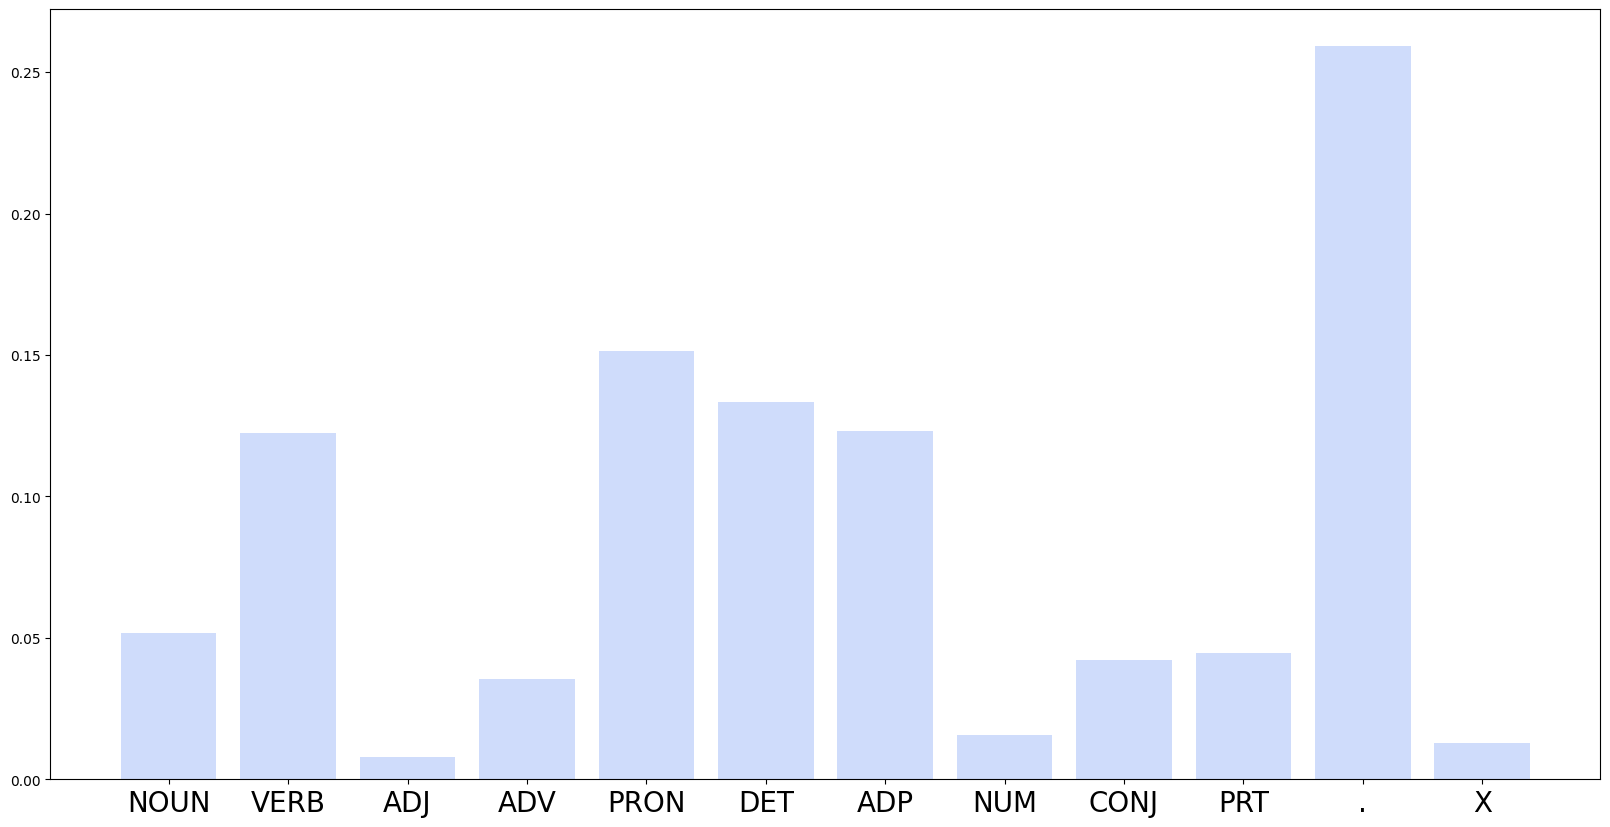

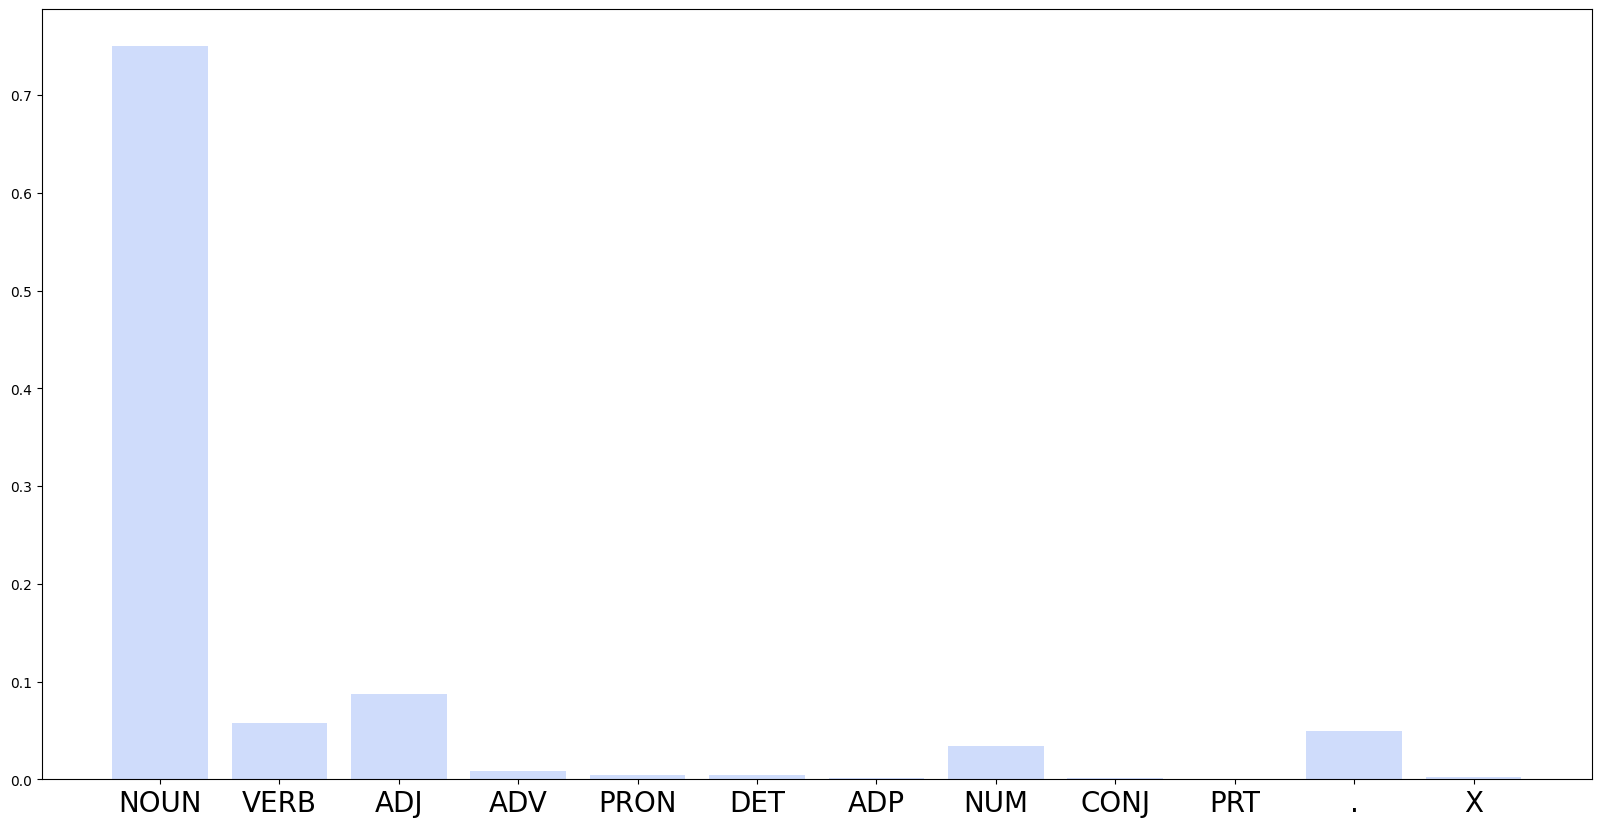

In [12]:
# Plot the distribution of the part-of-speech tags for the top 100 tokens
c1 = '#CFDCFB'
plt.figure(figsize=(20, 10))
plt.bar([POS_TAG_MAP_REVERSE[tag] for tag, count in enumerate(pos_counts_top)], [count for tag, count in enumerate(pos_counts_top)], color=c1)
#plt.xticks(rotation=90)
# font size for xticks
plt.xticks(fontsize=20)
plt.show()

# Plot the distribution of the part-of-speech tags for the bottom 100 tokens
plt.figure(figsize=(20, 10))
plt.bar([POS_TAG_MAP_REVERSE[tag] for tag, count in enumerate(pos_counts_top)], [count for tag, count in enumerate(pos_counts_bottom)], color=c1)
#plt.xticks(rotation=90)
# font size for xticks
plt.xticks(fontsize=20)
plt.show()

In [13]:
# For each token, get the distrubution of part-of-speech tags
pos_counts = pos_lookup.lookup_matrix[[a[0] for a in sorted_tokens]]
sums = pos_counts.sum(axis=0)

# Get cumulative distribution of part-of-speech tags, normalise by sums
cumulative_pos_counts = np.cumsum(pos_counts, axis=0) / sums

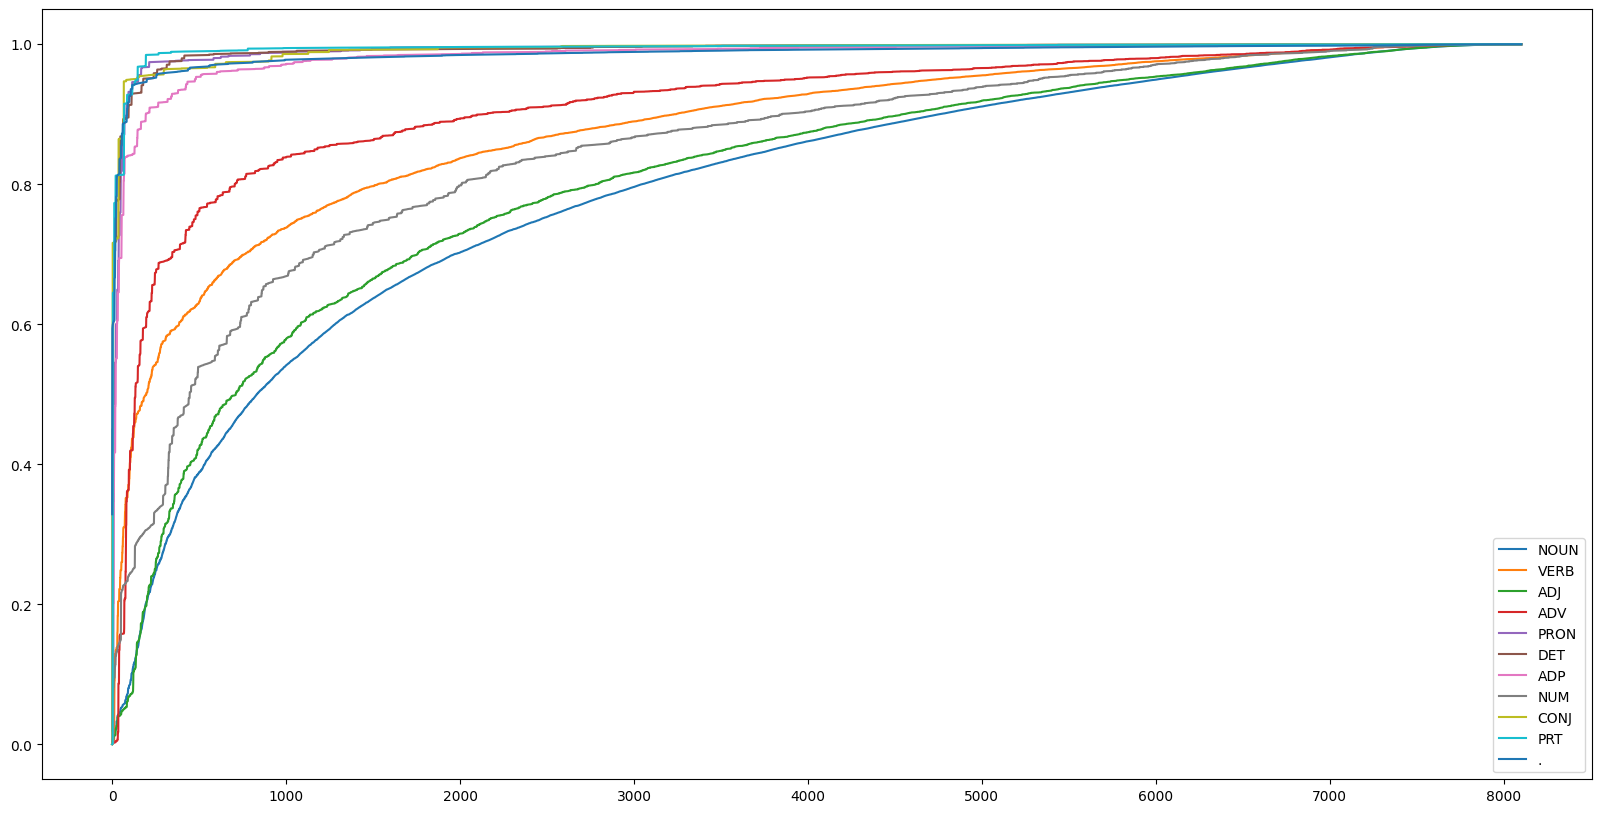

In [14]:
# Plot a cumulative distribution of pos tags counts across all tokens
plt.figure(figsize=(20, 10))
for pos_tag in POS_TAG_MAP.values():
   if pos_tag == 11:
       continue
   plt.plot(cumulative_pos_counts[:, pos_tag], label=POS_TAG_MAP_REVERSE[pos_tag])

plt.legend()
plt.show()



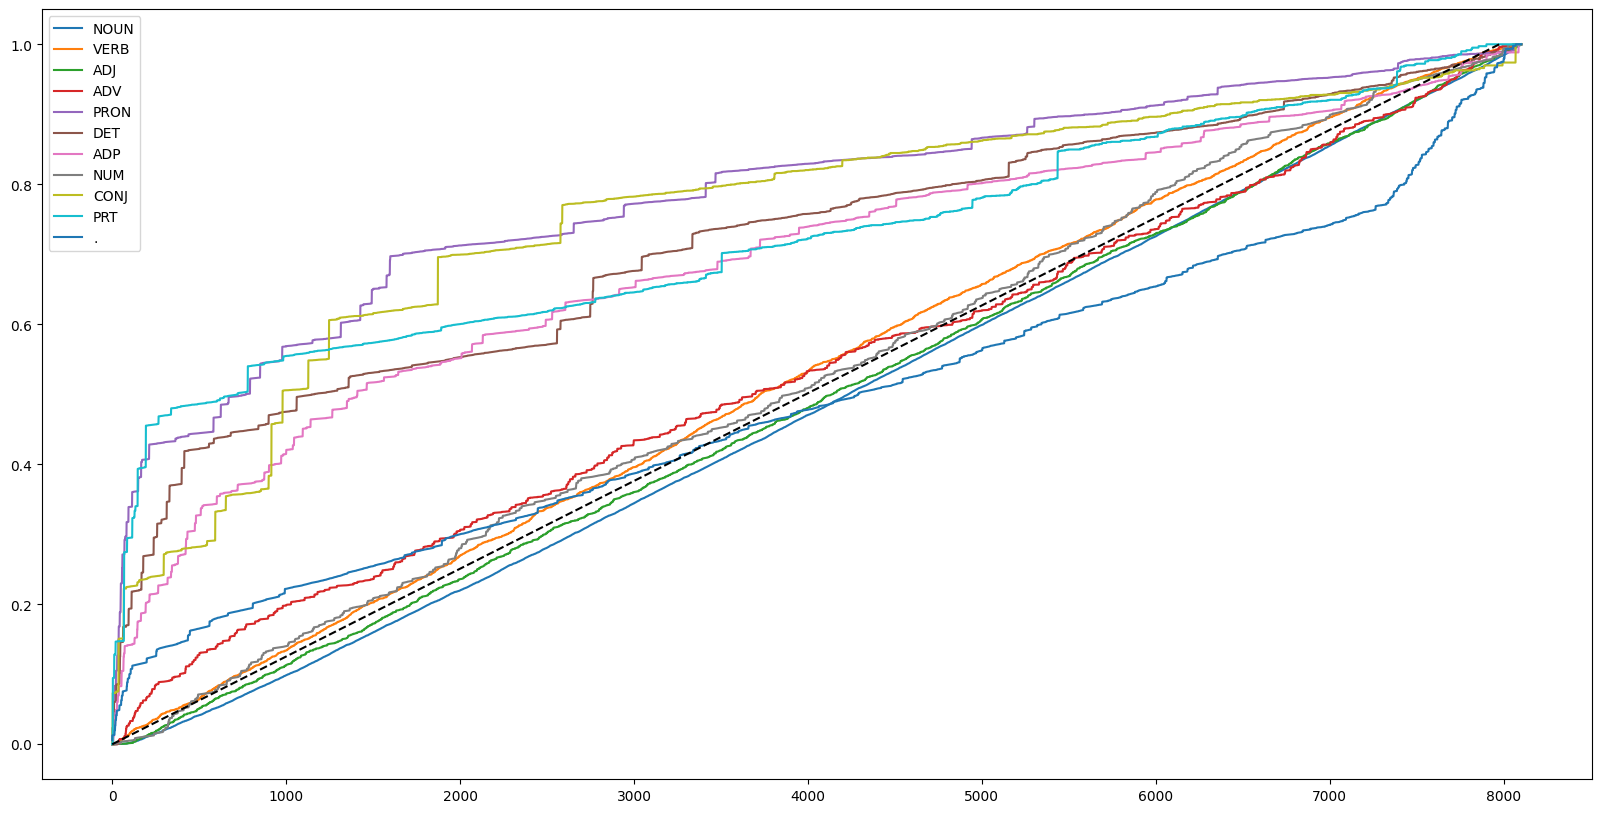

In [15]:
# Normalise for the frequency of each token
from torch import tensor
pos_counts = pos_lookup.lookup_matrix[[a[0] for a in sorted_tokens]]
pos_counts /= tensor([token[1] for token in sorted_tokens]).unsqueeze(1)
sums = pos_counts.sum(axis=0)

# Get cumulative distribution of part-of-speech tags, normalise by sums
cumulative_pos_counts = np.cumsum(pos_counts, axis=0) / sums

# Plot a cumulative distribution of pos tags counts across all tokens
plt.figure(figsize=(20, 10))
for pos_tag in POS_TAG_MAP.values():
   if pos_tag == 11:
       continue
   plt.plot(cumulative_pos_counts[:, pos_tag], label=POS_TAG_MAP_REVERSE[pos_tag])

plt.plot([0, 7975], [0, 1], color='black', linestyle='--')
plt.legend()
plt.show()



# Splitting BLIMP by rare subwords

In [16]:
CHECKPOINT = '../checkpoints/pos_merge-roberta_pre_layer_norm-model'
predictions_file = CHECKPOINT + '/lm_model/all_predictions.json'

#predictions_file = '../checkpoints/opt/all_predictions.json'
#predictions_file = '../checkpoints/roberta/all_predictions.json'
#predictions_file = '../checkpoints/t5/all_predictions.json'

import pandas as pd
from src.evaluators.blimp_bias_evaluator import BlimpBiasEvaluator, find_replaced_substring

In [17]:
evaluator = BlimpBiasEvaluator(predictions_file, tokenizer, pos_lookup, blimp_data_dir='../lib/evaluation-pipeline/filter-data/blimp_filtered')

Extracting data files: 100%|██████████| 1/1 [00:00<00:00, 602.02it/s]
Generating train split: 17 examples [00:00, 1134.48 examples/s]
Extracting data files: 100%|██████████| 1/1 [00:00<00:00, 221.82it/s]
Generating train split: 1965 examples [00:00, 391609.21 examples/s]
Extracting data files: 100%|██████████| 1/1 [00:00<00:00, 412.38it/s]
Generating train split: 4526 examples [00:00, 639086.32 examples/s]
Extracting data files: 100%|██████████| 1/1 [00:00<00:00, 493.10it/s]
Generating train split: 6738 examples [00:00, 895192.28 examples/s]
Extracting data files: 100%|██████████| 1/1 [00:00<00:00, 186.25it/s]
Generating train split: 1956 examples [00:00, 267660.39 examples/s]
Extracting data files: 100%|██████████| 1/1 [00:00<00:00, 319.49it/s]
Generating train split: 8248 examples [00:00, 1006828.27 examples/s]
Extracting data files: 100%|██████████| 1/1 [00:00<00:00, 275.78it/s]
Generating train split: 2676 examples [00:00, 508262.35 examples/s]
Extracting data files: 100%|█████████

In [18]:
result = evaluator()
# Convert to dataframe
df = pd.DataFrame(result, index=[0])
df.to_clipboard()

In [19]:
print('Example blimp data:')
print(evaluator.blimp_gold['anaphor_agreement'][0])

print('Example prediction:')
print(evaluator.predictions['predictions'][evaluator.predictions['sub_task'].index('anaphor_agreement')][0])

Example blimp data:
{'sentence_good': "Katherine can't help herself.", 'sentence_bad': "Katherine can't help himself.", 'field': 'morphology', 'linguistics_term': 'anaphor_agreement', 'UID': 'anaphor_gender_agreement', 'simple_LM_method': True, 'one_prefix_method': True, 'two_prefix_method': False, 'lexically_identical': False, 'pair_id': 0}
Example prediction:
{'id': 'anaphor_agreement_0', 'pred': "Katherine can't help herself."}


In [20]:
# Example addition tasks
print(find_replaced_substring([1,2,3,4,5], [1,2,3,4,5,6]))
print(find_replaced_substring([1,2,3,4,5], [1,2,3,3,4,5]))

# Example replacement tasks
print(find_replaced_substring([1,2,3,4,5], [1,2,3,6,6,5]))
print(find_replaced_substring([1,2,3,4,5], [1,2,8,4,5]))

# Example reordering tasks
print(find_replaced_substring([1,2,3,4,5], [1,2,4,3,5]))
print(find_replaced_substring([1,2,3,4,5], [1,2,3,5,4]))

# Example reordering and replacement
print(find_replaced_substring([1,2,3,4,5,6], [4,3,2,1,5,7]))
print(find_replaced_substring([1,2,3,4,5], [4,3,2,1,5]))

([], [6])
([], [3])
([4], [6, 6])
([3], [8])
([3, 4], [4, 3])
([4, 5], [5, 4])
([1, 2, 3, 6], [3, 2, 1, 7])
([1, 2, 3], [3, 2, 1])


In [21]:
evaluator.blimp_gold.keys()

dict_keys(['irregular_forms', 'control_raising', 'binding', 'anaphor_agreement', 'argument_structure', 'island_effects', 'quantifiers', 'subject_verb_agreement', 'npi_licensing', 'ellipsis', 'filler_gap', 'determiner_noun_agreement'])

In [22]:
prediction_data = evaluator.prediction_data
reordering_data = prediction_data[prediction_data['task_type'] == 'reordering']
replacement_data = prediction_data[prediction_data['task_type'] == 'replacement']
addition_data = prediction_data[prediction_data['task_type'] == 'addition']

In [23]:
len(prediction_data[prediction_data['task_type'] == 'replacement']['subtask'].unique())

53

In [24]:
for task in prediction_data['task'].unique():
    print(task)
    subtasks = prediction_data[prediction_data['task'] == task]['subtask'].unique()
    for subtask in subtasks:
        print(subtask)
        print(prediction_data[prediction_data['subtask'] == subtask]['task_type'].value_counts().to_dict())
        # Print first example good sentence and bad sentence
        data = prediction_data[prediction_data['subtask'] == subtask].iloc[0]
        good = data['sentence_good']
        bad = data['sentence_bad']
        frequency_diff = data['difference_average_frequency']
        differing_tokens = data['differing_tokens']
        print(good)
        print(bad)
        print(frequency_diff)
        for token in differing_tokens:
            print(token)
            print(pos_lookup.lookup_matrix[token].sum())
            print(tokenizer.decode([token]))
        

irregular_forms
irregular_past_participle_adjectives
{'replacement': 984}
The hidden offspring aren't confident.
The hid offspring aren't confident.
0.1910552978515625
4125
tensor(247.)
 hid
6014
tensor(299.)
 hidden
irregular_past_participle_verbs
{'replacement': 981}
The Borgias wore a lot of scarves.
The Borgias worn a lot of scarves.
0.3392157554626465
7472
tensor(208.)
 worn
6108
tensor(292.)
 wore
control_raising
existential_there_object_raising
{'replacement': 851}
William has declared there to be no guests getting fired.
William has obliged there to be no guests getting fired.
-2.039046287536621
7572
tensor(206.)
 oblig
5588
tensor(342.)
 declared
286
tensor(33518.)
ed
existential_there_subject_raising
{'replacement': 959}
There is soon to be a cat existing.
There is willing to be a cat existing.
1.6695022583007812
4327
tensor(504.)
 willing
1391
tensor(2676.)
 soon
expletive_it_object_raising
{'replacement': 801}
Tara would ascertain it to be noteworthy that Kenneth didn't was

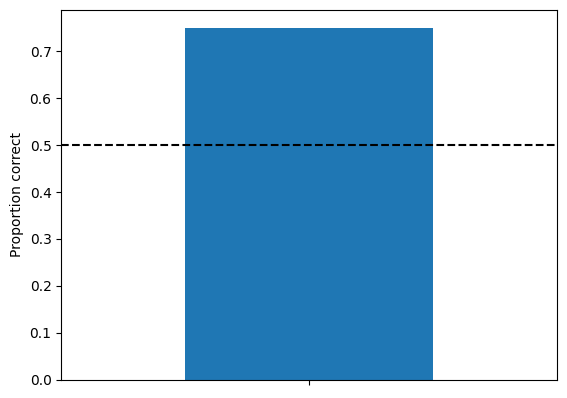

In [25]:
d = prediction_data['correct'].value_counts(normalize=True).drop([False]).plot(kind='bar')
d.set_xticklabels([])
d.set_xlabel('')
d.set_ylabel('Proportion correct')
plt.axhline(y=0.5, color='black', linestyle='--')
plt.show()


<Axes: xlabel='task_type'>

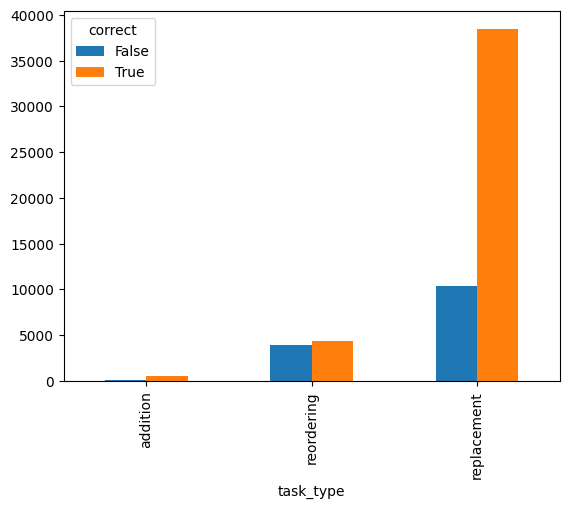

In [26]:
# Plot correct vs not correct for reordering tasks vs non-reordering tasks
prediction_data.groupby(['task_type', 'correct']).size().unstack().plot(kind='bar', stacked=False)

<Axes: xlabel='task_type'>

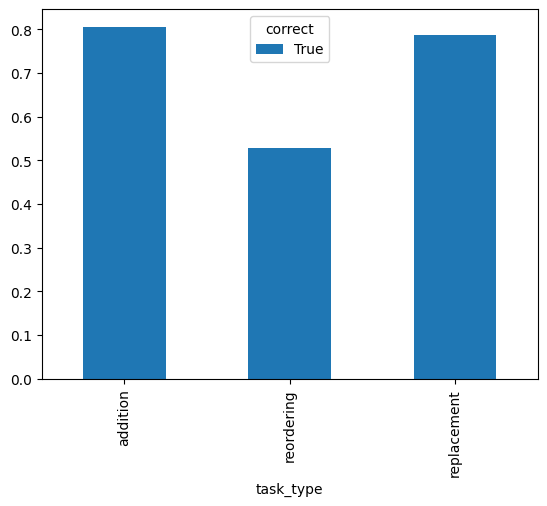

In [27]:
# BLIMP score for each task type
prediction_data.groupby(['task_type', 'correct']).size().unstack().apply(lambda x: x / x.sum(), axis=1).drop([False], axis=1).plot(kind='bar')

<Axes: xlabel='differing_tokens'>

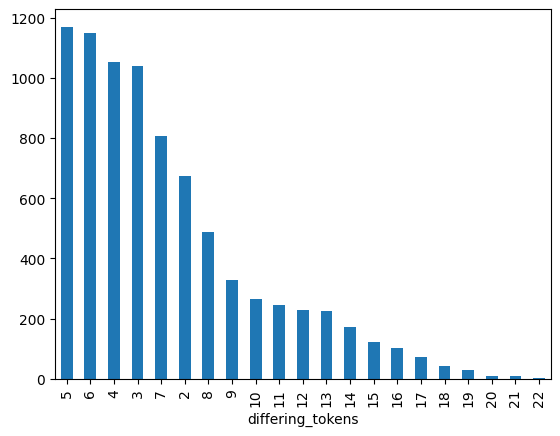

In [28]:
# Plot distribution of length of symmetric difference for reordering tasks
reordering_data['differing_tokens'].apply(lambda x: len(x)).value_counts().plot(kind='bar')

In [29]:
# Show example of one of the longest differences between two sentences
a = prediction_data[prediction_data['differing_tokens'].apply(lambda x: len(x) == 10)].iloc[0]
print(a['sentence_good'])
print(a['sentence_bad'])
print(a['differing_tokens'])
print(a)

a['average_frequency_all_tokens'].item()

April hadn't ascertained it to be unlucky that music bored Andrew.
April wasn't imploring it to be unlucky that music bored Andrew.
{352, 1254, 71, 360, 3501, 80, 786, 4821, 1595, 286}
correct                                                                      True
sentence_good                   April hadn't ascertained it to be unlucky that...
sentence_bad                    April wasn't imploring it to be unlucky that m...
task                                                              control_raising
subtask                                               expletive_it_object_raising
differing_tokens                {352, 1254, 71, 360, 3501, 80, 786, 4821, 1595...
average_frequency_key_tokens                                             8.444166
task_type                                                             replacement
average_frequency_all_tokens                                             9.087953
min_frequency_key_tokens                                                  5.5

9.087953309755068

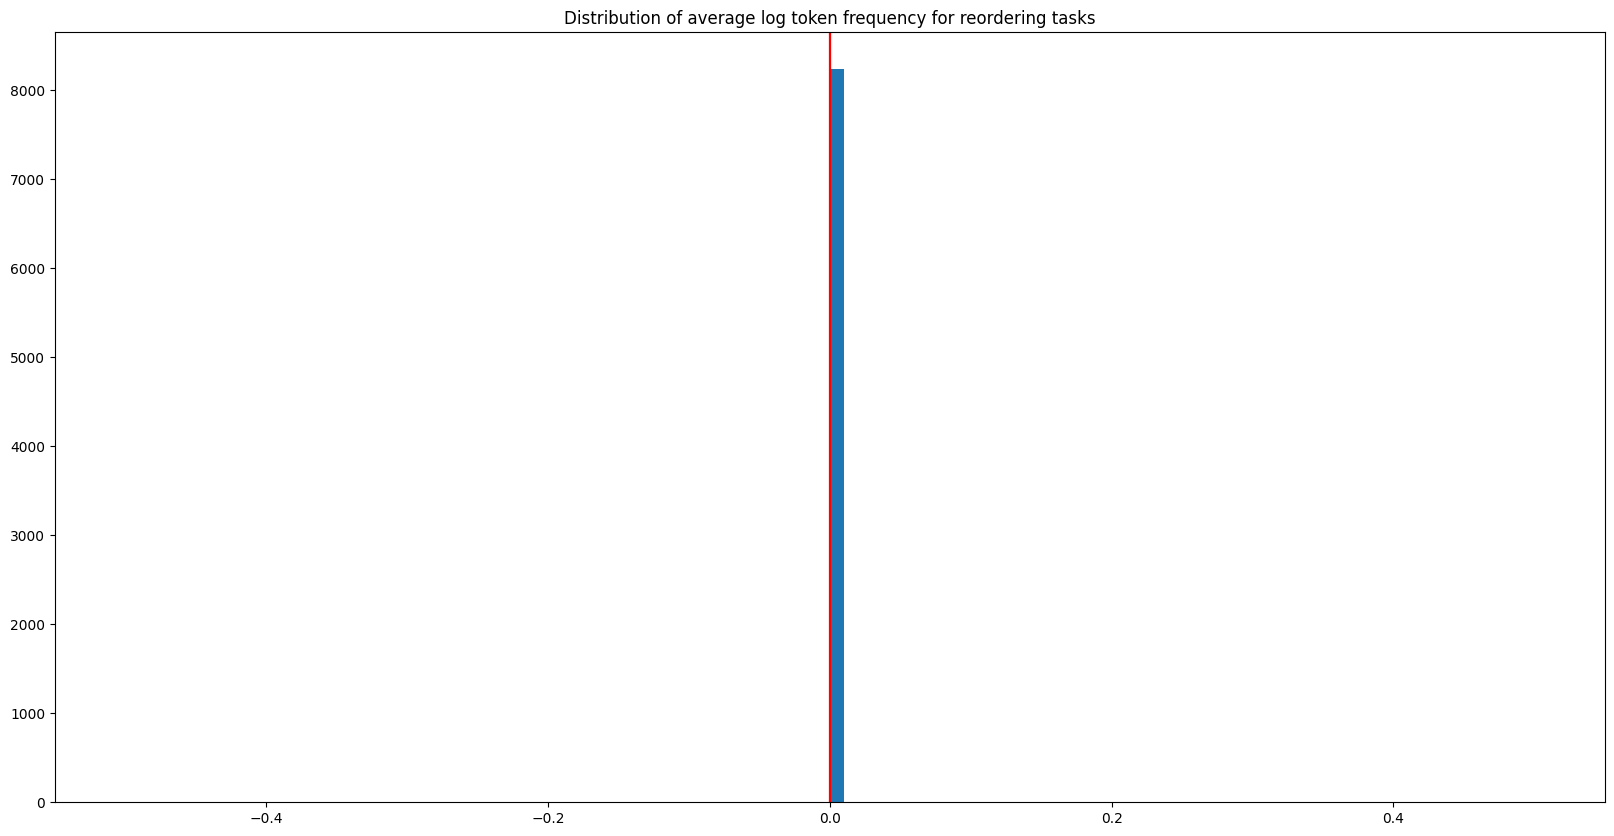

In [30]:
# Plot distribution of average token frequency for reordering tasks
a = reordering_data['difference_average_frequency']


plt.figure(figsize=(20, 10))
plt.hist(a, bins=100)
# Add 50th percentile, 90th percentile and 99th percentile
plt.axvline(x=np.percentile(a, 50), color='red')
plt.axvline(x=np.percentile(a, 90), color='red')
plt.axvline(x=np.percentile(a, 99), color='red')
# Add title
plt.title('Distribution of average log token frequency for reordering tasks')
plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


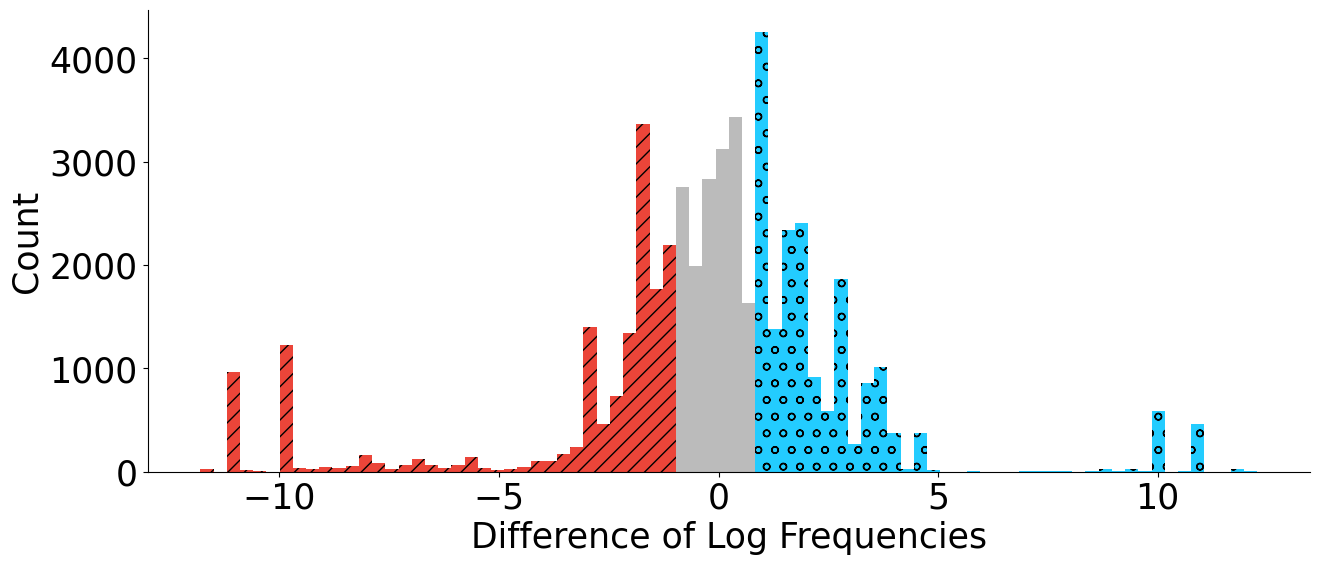

16083
16246
15460


In [31]:
# Plot distribution of average token frequency for key tokens in non-reordering tasks
a = replacement_data['difference_average_frequency']

c1 = '#EB4539'
c2 = '#23CCFF'

# Set text size to 20
plt.rcParams.update({'font.size': 25})

plt.figure(figsize=(15, 6))
plt.hist(a, bins=80, color='#BBBBBB')

# Remove top and right borders
plt.gca().spines['top'].set_visible(False) 
plt.gca().spines['right'].set_visible(False)

# Add 50th percentile, 90th percentile and 99th percentile
# plt.axvline(x=np.percentile(a, 33), color='black', label='33rd percentile')
# plt.axvline(x=np.percentile(a, 50), color='black',label='50th percentile')
# plt.axvline(x=np.percentile(a, 67), color='black',label='67th percentile')

# Set bars to the left of the 33rd percentile to stripey
for i in range(36):
    plt.gca().patches[i].set_hatch('//')
    plt.gca().patches[i].set_facecolor(c1)

# Set bars to the right of the 66th percentile to 
for i in range(42, 80):
    plt.gca().patches[i].set_hatch('o')
    plt.gca().patches[i].set_facecolor(c2)

# Add title
#plt.title('Distribution of the difference between average log token frequency for reordering tasks')
plt.ylabel('Count')
# Smaller font size
plt.xlabel('Difference of Log Frequencies')
# Hide legend
plt.legend().set_visible(False)
plt.show()

print(len(a[a < np.percentile(a, 33)]))
print(len(a[a > np.percentile(a, 66)]))
print(len(a[(a > np.percentile(a, 33)) & (a < np.percentile(a, 66))]))

# Now do the same but split for each subtask
# for subtask in replacement_data['subtask'].unique():
#     a = replacement_data[replacement_data['subtask'] == subtask]['difference_average_frequency']
#     plt.figure(figsize=(20, 10))
#     plt.hist(a, bins=100)
#     # Add 50th percentile, 90th percentile and 99th percentile
#     plt.axvline(x=np.percentile(a, 50), color='red')
#     plt.axvline(x=np.percentile(a, 90), color='red')
#     plt.axvline(x=np.percentile(a, 99), color='red')
#     # Add title
#     plt.title(subtask)
#     plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/var/folders/nz/6tzh0bsj2txd1cz18gpcms_c0000gn/T/ipykernel_88431/4094838748.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['50%', '55%', '60%', '65%', '70%'])


Text(0, 0.5, 'BLiMP Score')

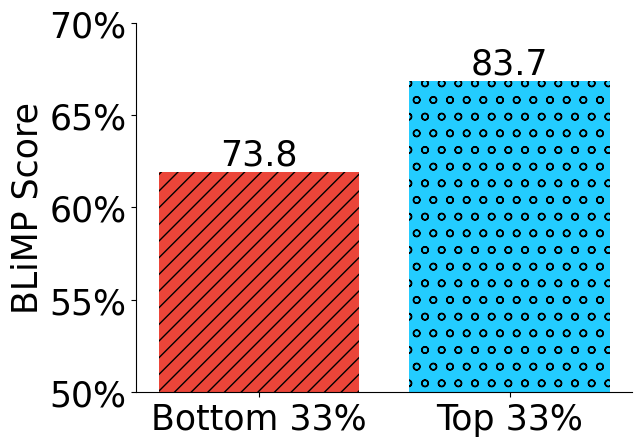

In [32]:
#replacement_data.groupby(['correct']).size().unstack().apply(lambda x: x / x.sum(), axis=1).drop([False], axis=1).plot(kind='bar')

top = replacement_data[replacement_data['difference_average_frequency'] > replacement_data['difference_average_frequency'].quantile(0.67)]['correct'].mean()
bottom = replacement_data[replacement_data['difference_average_frequency'] < replacement_data['difference_average_frequency'].quantile(0.33)]['correct'].mean()
fig, ax = plt.subplots()
ax.bar(x=[0, 1], height=[bottom, top], color=[c1, c2], tick_label=['Bottom 33%', 'Top 33%'], hatch=['//', 'o'])

ax.legend().set_visible(False)
ax.set_ylim([0.5, 0.9])
ax.set_yticklabels(['50%', '55%', '60%', '65%', '70%'])
# Set y axis label
# Remove top and right borders
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Add error bar showing difference between two scores with label showing value
#bias = top - bottom
#ax.errorbar(x=[0], y=[bottom + bias/2], yerr=[bias/2], color='black', capsize=5, label='Bias')
#ax.annotate('Bias = {:.2f}'.format(bias), xy=(0, bottom + bias/2), ha='center', va='center')

# Show score in each bar
ax.annotate('{:.1f}'.format(bottom*100), xy=(0, bottom), ha='center', va='bottom')
ax.annotate('{:.1f}'.format(top*100), xy=(1, top), ha='center', va='bottom')

ax.set_ylabel('BLiMP Score')



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/var/folders/nz/6tzh0bsj2txd1cz18gpcms_c0000gn/T/ipykernel_88431/2861025255.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['50%', '55%', '60%', '65%', '70%'])


Text(0, 0.5, 'BLiMP Score')

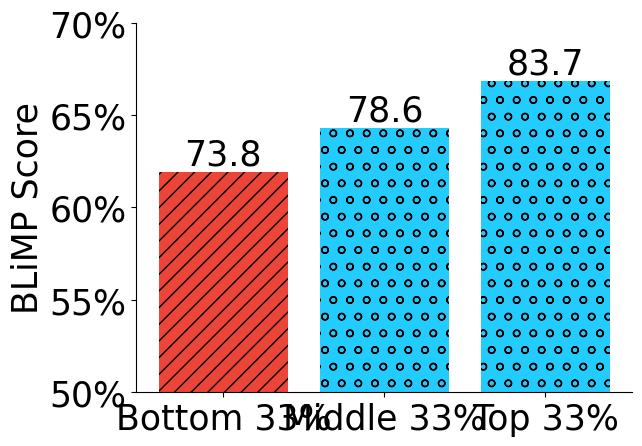

In [35]:
#replacement_data.groupby(['correct']).size().unstack().apply(lambda x: x / x.sum(), axis=1).drop([False], axis=1).plot(kind='bar')

top = replacement_data[replacement_data['difference_average_frequency'] > replacement_data['difference_average_frequency'].quantile(0.67)]['correct'].mean()
bottom = replacement_data[replacement_data['difference_average_frequency'] < replacement_data['difference_average_frequency'].quantile(0.33)]['correct'].mean()
middle = replacement_data[(replacement_data['difference_average_frequency'] > replacement_data['difference_average_frequency'].quantile(0.33)) & (replacement_data['difference_average_frequency'] < replacement_data['difference_average_frequency'].quantile(0.67))]['correct'].mean()
fig, ax = plt.subplots()
ax.bar(x=[0, 1, 2], height=[bottom, middle, top], color=[c1, c2, c2], tick_label=['Bottom 33%', 'Middle 33%', 'Top 33%'], hatch=['//', 'o', 'o'])

ax.legend().set_visible(False)
ax.set_ylim([0.5, 0.9])
ax.set_yticklabels(['50%', '55%', '60%', '65%', '70%'])
# Set y axis label
# Remove top and right borders
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Add error bar showing difference between two scores with label showing value
#bias = top - bottom
#ax.errorbar(x=[0], y=[bottom + bias/2], yerr=[bias/2], color='black', capsize=5, label='Bias')
#ax.annotate('Bias = {:.2f}'.format(bias), xy=(0, bottom + bias/2), ha='center', va='center')

# Show score in each bar
ax.annotate('{:.1f}'.format(bottom*100), xy=(0, bottom), ha='center', va='bottom')
ax.annotate('{:.1f}'.format(middle*100), xy=(1, middle), ha='center', va='bottom')
ax.annotate('{:.1f}'.format(top*100), xy=(2, top), ha='center', va='bottom')

ax.set_ylabel('BLiMP Score')



In [ ]:
# Show example of one of the sentences with the lowest average frequency of key tokens
# Sort by average frequency and take the first example

not_tokens = [316, 812, 332, 364, 504, 1156]

i = 41702
found = False
while not found:
    i += 1
    a = replacement_data.sort_values(by=['difference_average_frequency'], ascending=True).iloc[i]
    if len(a['differing_tokens']) < 3 and len(a['sentence_good']) < 50:
        for freq in [pos_lookup.lookup_matrix[token].sum() for token in a['differing_tokens']]:
            if freq < 1000:
                found = True
        for token in not_tokens:
            if token in a['differing_tokens']:
                found = False
print(i)
print(a['sentence_good'])
print(a['sentence_bad'])
print('Average frequency of all tokens:', a['average_frequency_all_tokens'])
print(a['differing_tokens'],'=',[tokenizer.decode([token]) for token in a['differing_tokens']])
differing_tokens_frequencies = {token : pos_lookup.lookup_matrix[token].sum() for token in a['differing_tokens']}
print(differing_tokens_frequencies)
print(a['difference_average_frequency'])
frequencies = [token_counts[token] for token in tokenizer.encode(a['sentence_good']) if not token in special_ids]
#print('Tokens:' , [tokenizer.decode([token]) for token in tokenizer.encode(a['sentence_good']) if not token in special_ids])
print(frequencies)
    

41714
Grace's piano teachers are known.
Grace's piano teachers are replied.
Average frequency of all tokens: 8.711827959333148
{4384, 1101} = [' replied', ' known']
{4384: tensor(493.), 1101: tensor(4234.)}
2.150393486022949
[tensor(379.), tensor(128552.), tensor(361.), tensor(361.), tensor(49958.), tensor(4234.), tensor(665815.)]


In [ ]:
a.keys()

Index(['correct', 'sentence_good', 'sentence_bad', 'task', 'subtask',
       'differing_tokens', 'average_frequency_key_tokens', 'task_type',
       'average_frequency_all_tokens', 'min_frequency_key_tokens',
       'min_frequency_all_tokens', 'difference_average_frequency',
       'difference_min_frequency'],
      dtype='object')

/var/folders/nz/6tzh0bsj2txd1cz18gpcms_c0000gn/T/ipykernel_48223/1955300690.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['high_frequency'] = data[frequency_column].apply(lambda x: x > percentile)


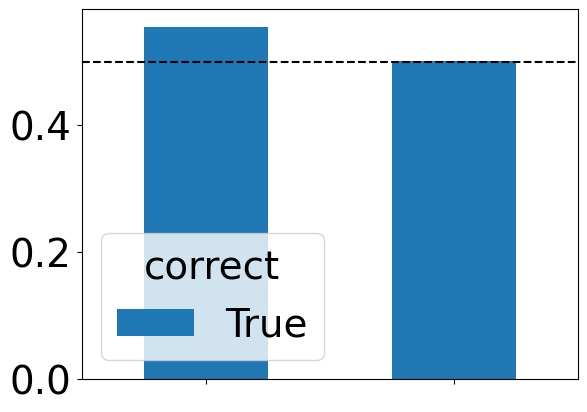

In [ ]:
def plot_correct_incorrect_for_frequency(data, percentile, frequency_column='average_frequency_all_tokens'):
    percentile = np.percentile(data[frequency_column], percentile)
    data['high_frequency'] = data[frequency_column].apply(lambda x: x > percentile)
    # Get number of correct and incorrect predictions for each group as a percentage of the total number of predictions
    d = data.groupby(['high_frequency', 'correct']).size().unstack().apply(lambda x: x / x.sum(), axis=1).drop([False], axis=1).plot(kind='bar', stacked=False)
    d.set_xticklabels([])
    d.set_xlabel('')
    # Add dashed line at 0.5
    plt.axhline(y=0.5, color='black', linestyle='--')

plot_correct_incorrect_for_frequency(reordering_data, 50, frequency_column='min_frequency_all_tokens')


/var/folders/nz/6tzh0bsj2txd1cz18gpcms_c0000gn/T/ipykernel_48223/1955300690.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['high_frequency'] = data[frequency_column].apply(lambda x: x > percentile)


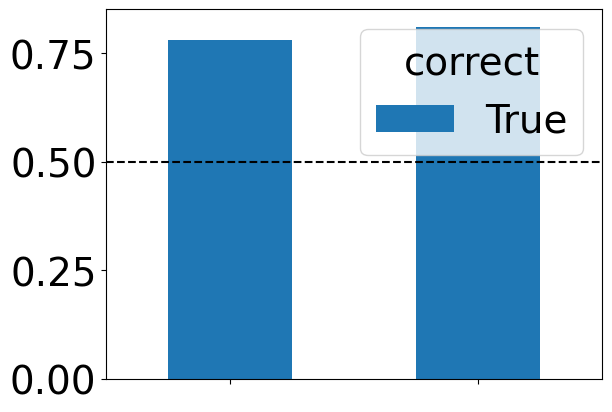

In [ ]:
plot_correct_incorrect_for_frequency(replacement_data, 80, 'difference_min_frequency')

In [ ]:
split_data = evaluator.get_split_scores_per_task('replacement', 33, 66, 'difference_average_frequency')
increasing = sum([split_data[task]['high_frequency'] - split_data[task]['low_frequency'] for task in split_data if split_data[task]['low_frequency'] != 0 and split_data[task]['high_frequency'] != 0])
total = sum([1 for task in split_data if split_data[task]['low_frequency'] != 0 and split_data[task]['high_frequency'] != 0])
print(increasing / total)

split_scores_all = evaluator.get_split_scores_all('replacement', 33, 66, 'difference_average_frequency')
print(split_scores_all['high_frequency'] - split_scores_all['low_frequency'])

split_scores_all_by_task = evaluator.get_split_scores_all_by_task('replacement', 33, 66, 'difference_average_frequency')
print(split_scores_all_by_task['high_frequency'] - split_scores_all_by_task['low_frequency'])

0.09463961304887591
0.09827819123909642
0.10513830700949445


Percentage count increasing: 81.3953488372093


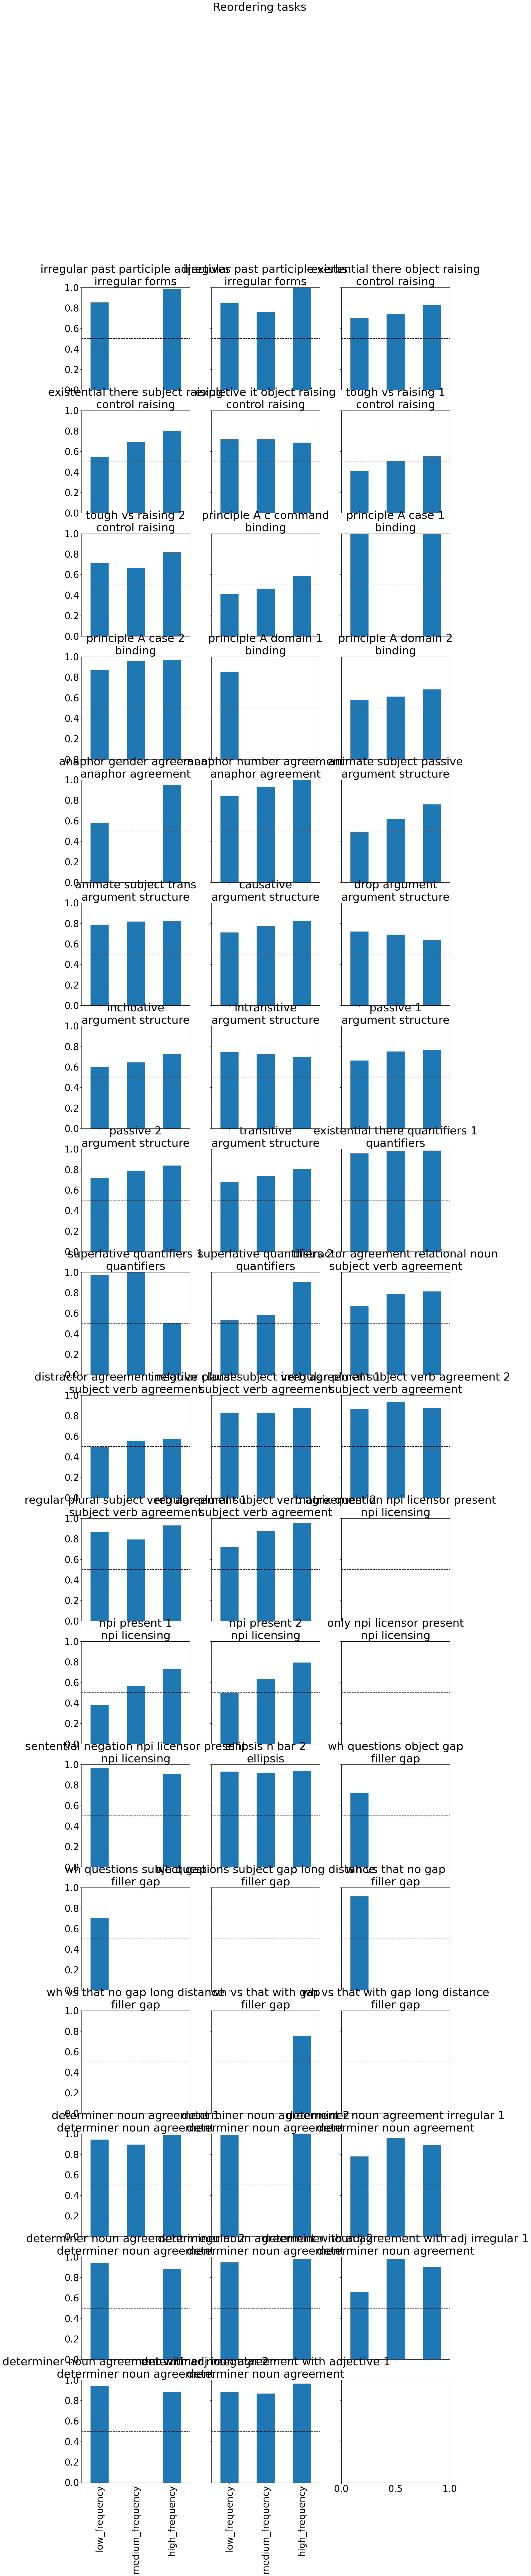

In [ ]:
def plot_split_data(split_data):
    num_tasks = split_data.shape[1]
    fig, axs = plt.subplots(num_tasks // 3 + 1, 3, figsize=(20, 20 * (num_tasks // 3 + 1) / 3))
    count_increasing = 0
    total = 0
    for i, task in enumerate(split_data):
        ax = axs[i // 3, i % 3,]
        split_data[task].plot(kind='bar', stacked=False, ax=ax)
        # Add dashed line at 0.5
        ax.axhline(y=0.5, color='black', linestyle='--')
        # Add one to count_increasing if the proportion of correct predictions increases from the bottom to the top
        if split_data[task]['low_frequency'] != 0 and split_data[task]['high_frequency'] != 0:
            total += 1
            if split_data[task]['low_frequency'] < split_data[task]['high_frequency']:
                count_increasing += 1
        ax.set_xlabel('')
        ax.set_title(task)
    print('Percentage count increasing:', count_increasing / total * 100)
    fig.suptitle('Reordering tasks')
    # Hide x labels unless it is the bottom row
    for ax in axs.flat:
        ax.label_outer()
    # Ensure scale is always 0 to 1
    for ax in axs.flat:
        ax.set_ylim([0, 1])
    
    #fig.tight_layout()
    # Hide x label
    #fig.tight_layout()
    plt.show()

plot_split_data(split_data)

In [ ]:
good = a['sentence_good']
bad = a['sentence_bad']

# Find the two words that were swapped between the two sentences
good_tokens = tokenizer.encode(good)
bad_tokens = tokenizer.encode(bad)
good_tokens = [tokenizer.decode([token]) for token in good_tokens]
bad_tokens = [tokenizer.decode([token]) for token in bad_tokens]
print(good_tokens)
print(bad_tokens)

for i in range(len(good_tokens)):
    if good_tokens[i] != bad_tokens[i]:
        print(f'Index {i} is different: {good_tokens[i]} vs {bad_tokens[i]}')


['<s>', ' grace', "'s", ' piano', ' teachers', ' are', ' known', '.', '</s>']
['<s>', ' grace', "'s", ' piano', ' teachers', ' are', ' replied', '.', '</s>']
Index 6 is different:  known vs  replied


In [ ]:
# Pick first example given a subtask
def get_example(data, subtask):
    print(data[data['subtask'] == subtask].iloc[0])
    # Print frequencies of each differing token
    print('Frequencies of each differing token:')
    print([token_counts[token] for token in data[data['subtask'] == subtask].iloc[0]['differing_tokens']])
    print('Tokens:')
    print([tokenizer.decode([token]) for token in data[data['subtask'] == subtask].iloc[0]['differing_tokens']])


get_example(replacement_data, 'irregular_past_participle_verbs')

correct                                                       True
sentence_good                   The Borgias wore a lot of scarves.
sentence_bad                    The Borgias worn a lot of scarves.
task                                               irregular_forms
subtask                            irregular_past_participle_verbs
differing_tokens                                      {7472, 6108}
average_frequency_key_tokens                              5.507146
task_type                                              replacement
average_frequency_all_tokens                              9.005148
min_frequency_key_tokens                                  5.337538
min_frequency_all_tokens                                  5.337538
difference_average_frequency                              0.339216
difference_min_frequency                                  0.339216
high_frequency                                               False
Name: 984, dtype: object
Frequencies of each differing token:


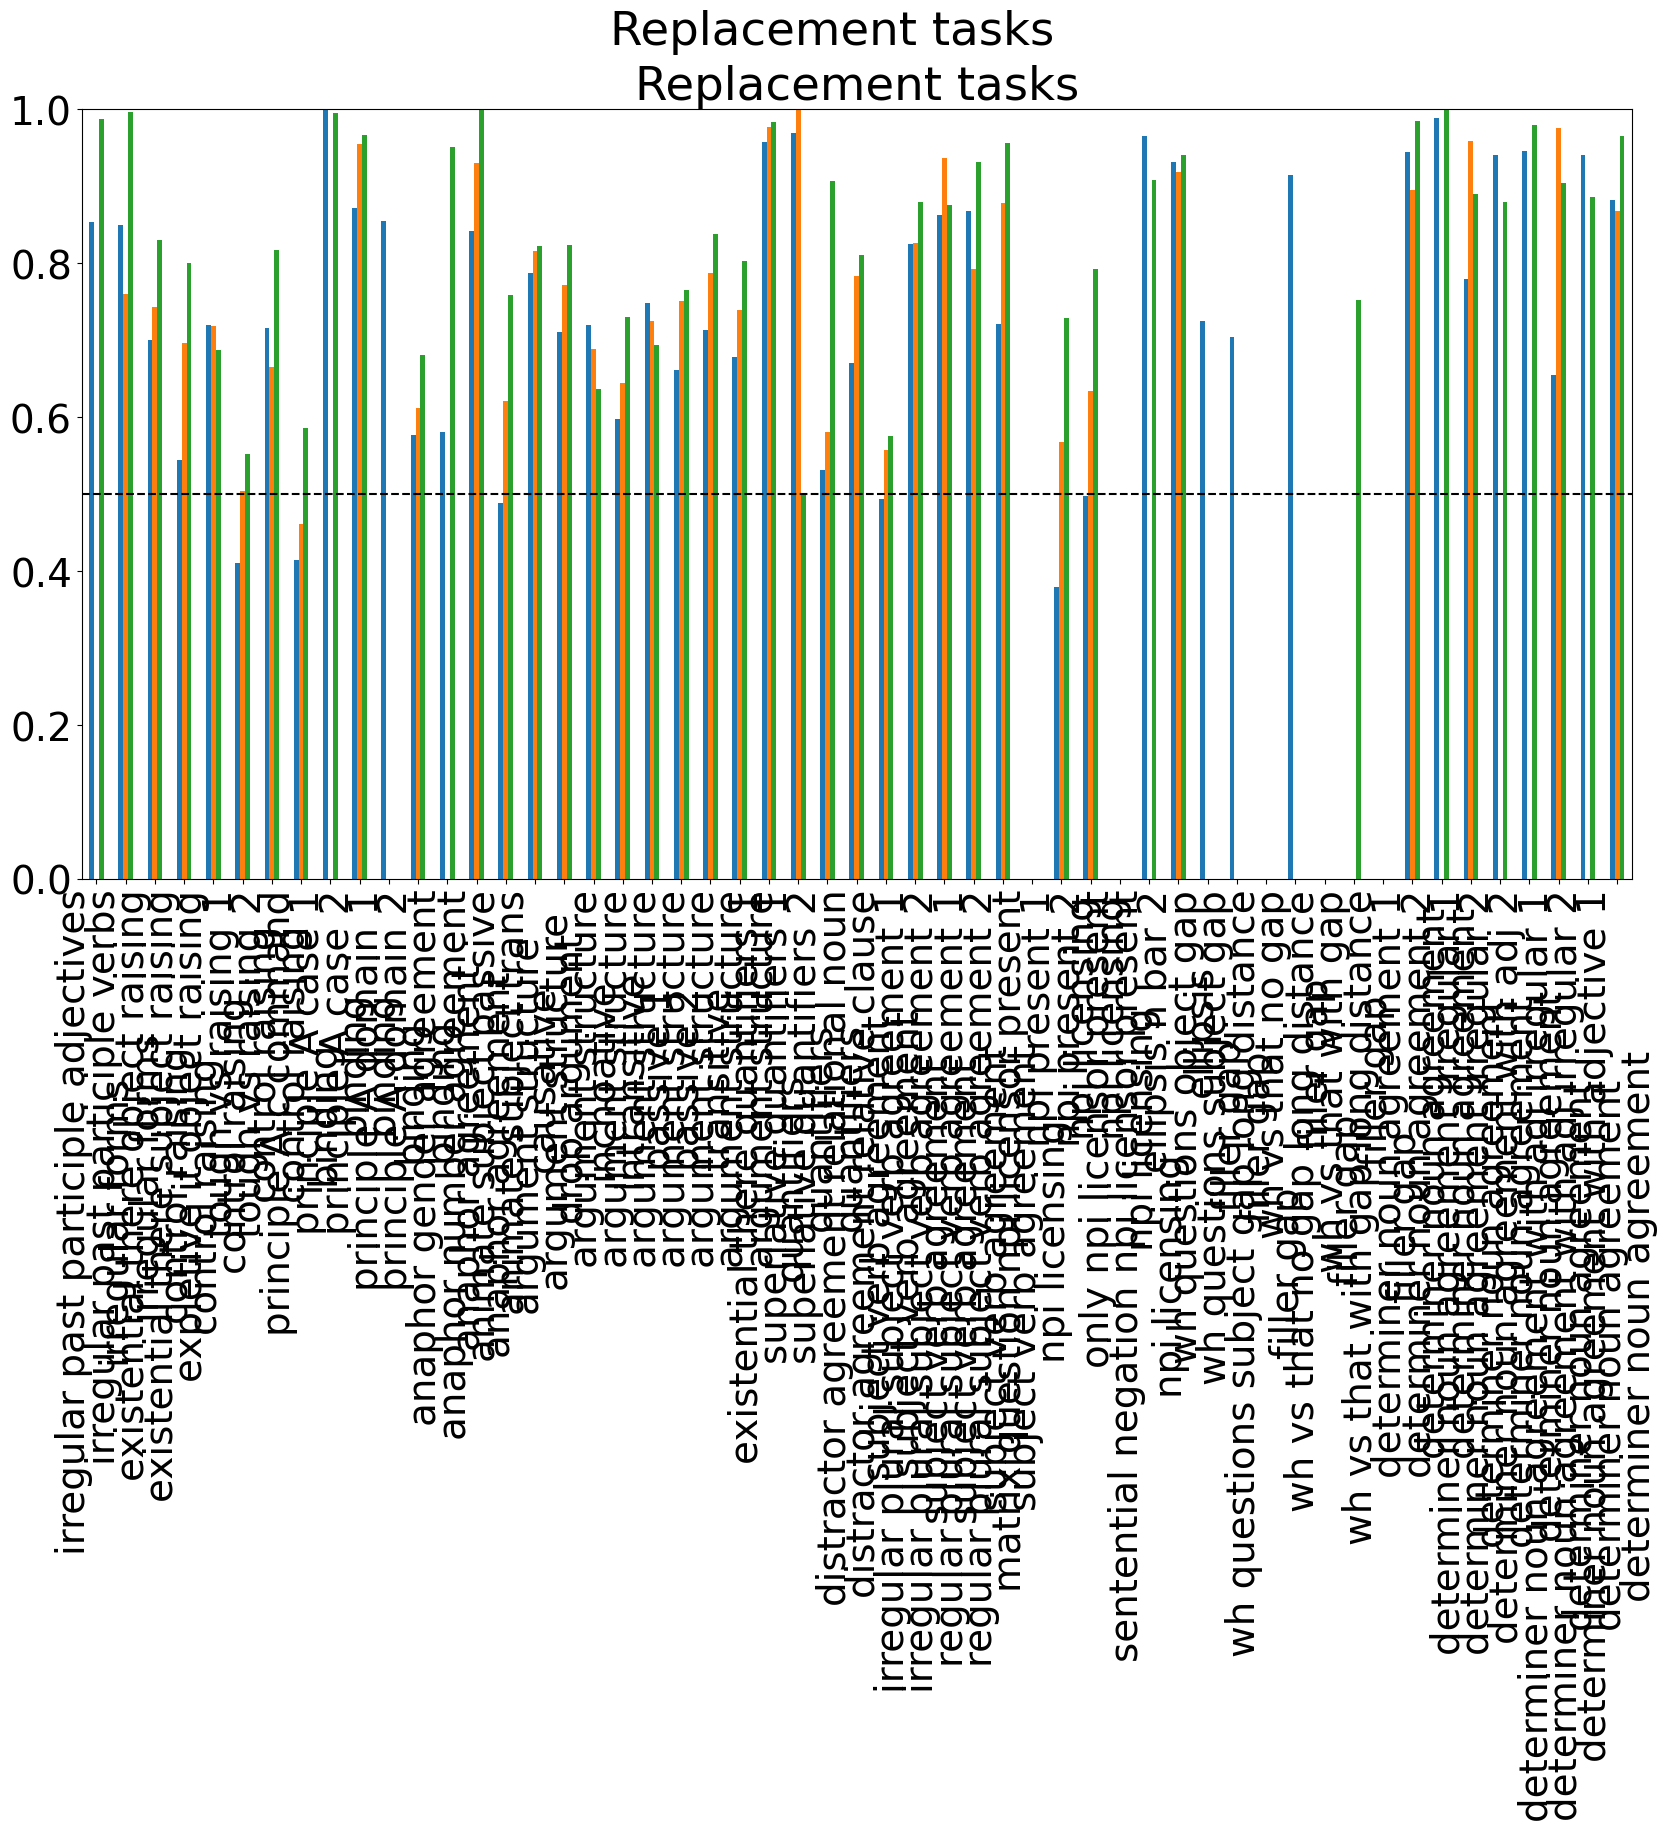

In [ ]:
r = evaluator.get_split_scores_per_task('replacement', 33, 66, 'difference_average_frequency')
r = pd.DataFrame(r).transpose()
# Plot the results
fig, axs = plt.subplots(1, 1, figsize=(20, 10))
r.plot(kind='bar', stacked=False, ax=axs)
# Add dashed line at 0.5
axs.axhline(y=0.5, color='black', linestyle='--')
# Hide x label
axs.set_xlabel('')
axs.set_title('Replacement tasks')
axs.get_legend().remove()
fig.suptitle('Replacement tasks')
# Hide x labels unless it is the bottom row
axs.label_outer()
# Ensure scale is always 0 to 1
axs.set_ylim([0, 1])
plt.show()


In [ ]:
r

,low_frequency,medium_frequency,high_frequency
irregular past participle adjectives\nirregular forms,0.854015,0.000000,0.987382
irregular past participle verbs\nirregular forms,0.849593,0.760870,0.996825
existential there object raising\ncontrol raising,0.701068,0.742857,0.830450
existential there subject raising\ncontrol raising,0.544304,0.696486,0.800000
expletive it object raising\ncontrol raising,0.719697,0.718631,0.687500
tough vs raising 1\ncontrol raising,0.411392,0.504886,0.552147
tough vs raising 2\ncontrol raising,0.715655,0.665595,0.817035
principle A c command\nbinding,0.414557,0.462069,0.585859
principle A case 1\nbinding,1.000000,0.000000,0.995475
principle A case 2\nbinding,0.872414,0.955172,0.967105


In [ ]:
evaluator.get_split_scores_per_task('replacement', 33, 66, 'difference_average_frequency')

,irregular past participle adjectives\nirregular forms,irregular past participle verbs\nirregular forms,existential there object raising\ncontrol raising,existential there subject raising\ncontrol raising,expletive it object raising\ncontrol raising,tough vs raising 1\ncontrol raising,tough vs raising 2\ncontrol raising,principle A c command\nbinding,principle A case 1\nbinding,principle A case 2\nbinding,...,wh vs that with gap\nfiller gap,wh vs that with gap long distance\nfiller gap,determiner noun agreement 1\ndeterminer noun agreement,determiner noun agreement 2\ndeterminer noun agreement,determiner noun agreement irregular 1\ndeterminer noun agreement,determiner noun agreement irregular 2\ndeterminer noun agreement,determiner noun agreement with adj 2\ndeterminer noun agreement,determiner noun agreement with adj irregular 1\ndeterminer noun agreement,determiner noun agreement with adj irregular 2\ndeterminer noun agreement,determiner noun agreement with adjective 1\ndeterminer noun agreement
low_frequency,0.854015,0.849593,0.701068,0.544304,0.719697,0.411392,0.715655,0.414557,1.000000,0.872414,...,0.000000,0,0.944056,0.988506,0.779783,0.940426,0.945946,0.655629,0.940171,0.881720
medium_frequency,0.000000,0.760870,0.742857,0.696486,0.718631,0.504886,0.665595,0.462069,0.000000,0.955172,...,0.000000,0,0.894737,0.000000,0.958647,0.000000,0.000000,0.976027,0.000000,0.868132
high_frequency,0.987382,0.996825,0.830450,0.800000,0.687500,0.552147,0.817035,0.585859,0.995475,0.967105,...,0.752941,0,0.985401,1.000000,0.889734,0.880150,0.979253,0.904605,0.886364,0.965157


# Perplexity

In [ ]:
PERPLEXITY_FILE = '../checkpoints/baseline-roberta_pre_layer_norm-model/lm_model/predictions.json'

In [ ]:
perplexities = load_dataset('json', data_files=PERPLEXITY_FILE, split='train', field='predictions').to_pandas()

In [ ]:
perplexities

,perplexity,per_token_loss,id,input_ids
0,496.920380,"[0.0, 4.240802764892578, 7.9829559326171875, 9...",perplexity_0,"[3, 264, 773, 1852, 382, 364, 568, 266, 7056, ..."
1,575.749878,"[2.999039649963379, 11.116632461547852, 11.168...",perplexity_1,"[18, 6524, 4867, 320, 321, 597, 284, 1448, 291..."
2,466.098633,"[7.5909037590026855, 4.170400142669678, 9.5199...",perplexity_2,"[301, 284, 2226, 1197, 18, 307, 317, 380, 266,..."
3,400.834595,"[5.043636322021484, 5.644055366516113, 4.14707...",perplexity_3,"[321, 376, 263, 6077, 18, 518, 366, 2748, 18, ..."
4,791.233093,"[7.767001628875732, 7.506594657897949, 4.33121...",perplexity_4,"[760, 704, 291, 1907, 264, 528, 315, 4816, 411..."
...,...,...,...,...
96,3413.177246,"[5.323674201965332, 6.272162437438965, 6.29776...",perplexity_96,"[361, 354, 354, 79, 312, 6681, 360, 401, 2044,..."
97,2588.086670,"[5.97589111328125, 7.933274269104004, 7.783666...",perplexity_97,"[453, 268, 312, 990, 295, 1715, 16, 3514, 16, ..."
98,2399.533203,"[7.08505392074585, 4.672813892364502, 6.802525...",perplexity_98,"[31, 307, 650, 5614, 5200, 3967, 266, 3670, 42..."
99,2183.149414,"[11.935686111450195, 4.019516944885254, 9.0196...",perplexity_99,"[5893, 294, 3894, 18, 360, 897, 1654, 998, 420..."


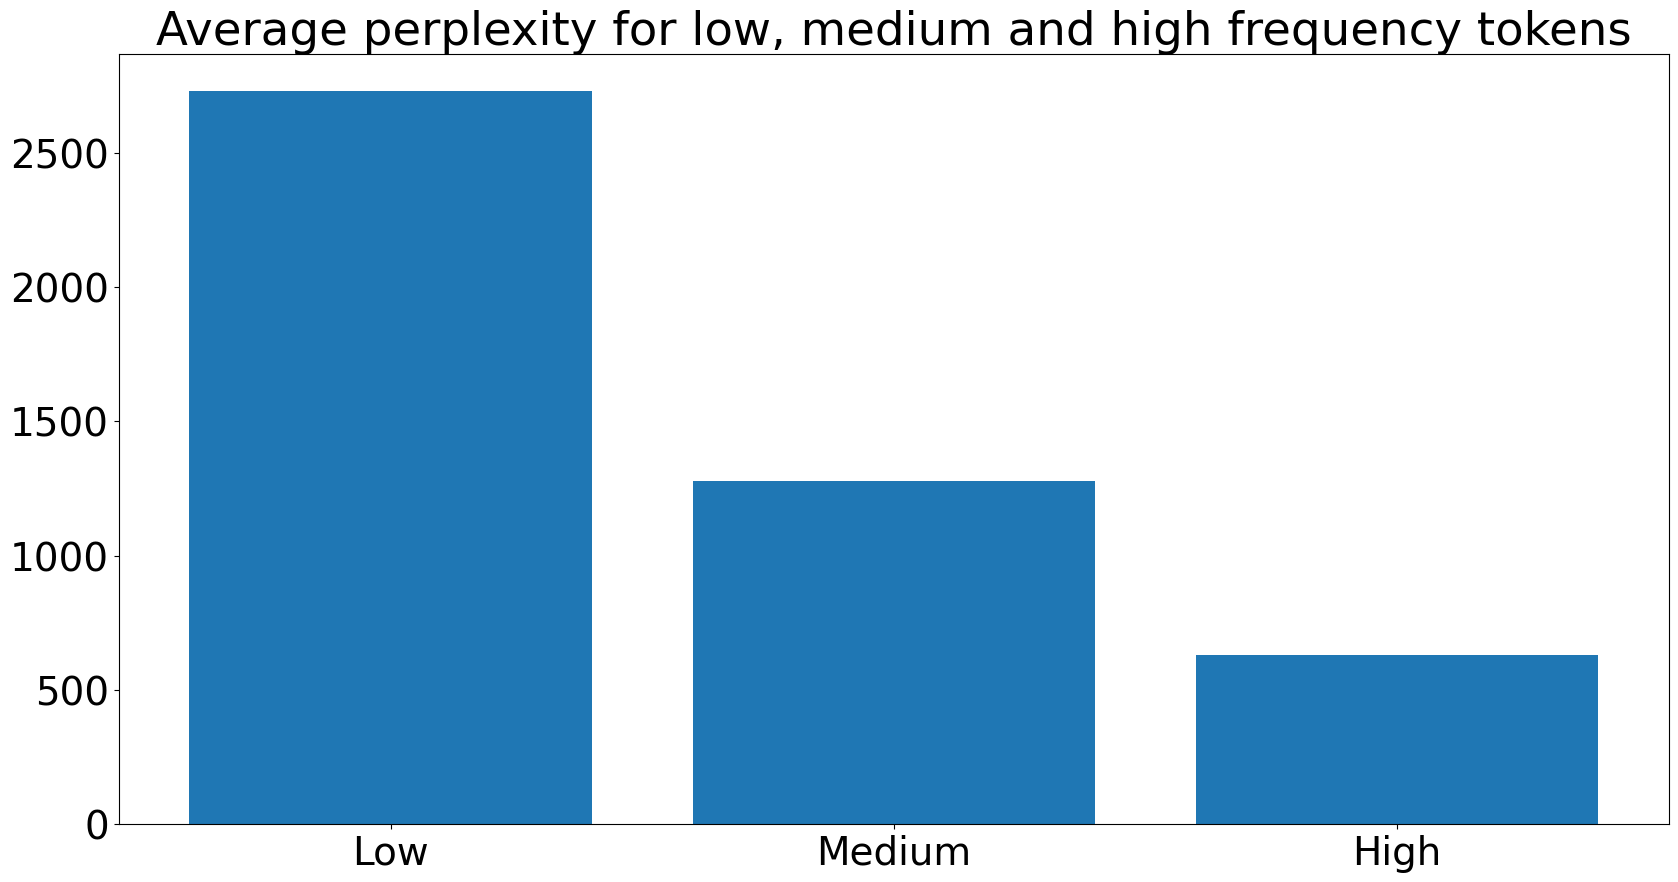

In [ ]:
perplexities['average_frequency'] = perplexities['input_ids'].apply(lambda tokens: np.mean(np.log([token_counts[token] for token in tokens if not token in special_ids])))
lower_percentile = np.percentile(perplexities['average_frequency'], 33)
upper_percentile = np.percentile(perplexities['average_frequency'], 66)

# Plot average perplexity for low, medium and high frequency tokens
perplexity_low = perplexities[perplexities['average_frequency'] < lower_percentile]['perplexity'].mean()
perplexity_medium = perplexities[(perplexities['average_frequency'] >= lower_percentile) & (perplexities['average_frequency'] < upper_percentile)]['perplexity'].mean()
perplexity_high = perplexities[perplexities['average_frequency'] >= upper_percentile]['perplexity'].mean()

plt.figure(figsize=(20, 10))
plt.bar(['Low', 'Medium', 'High'], [perplexity_low, perplexity_medium, perplexity_high])
plt.title('Average perplexity for low, medium and high frequency tokens')
plt.show()


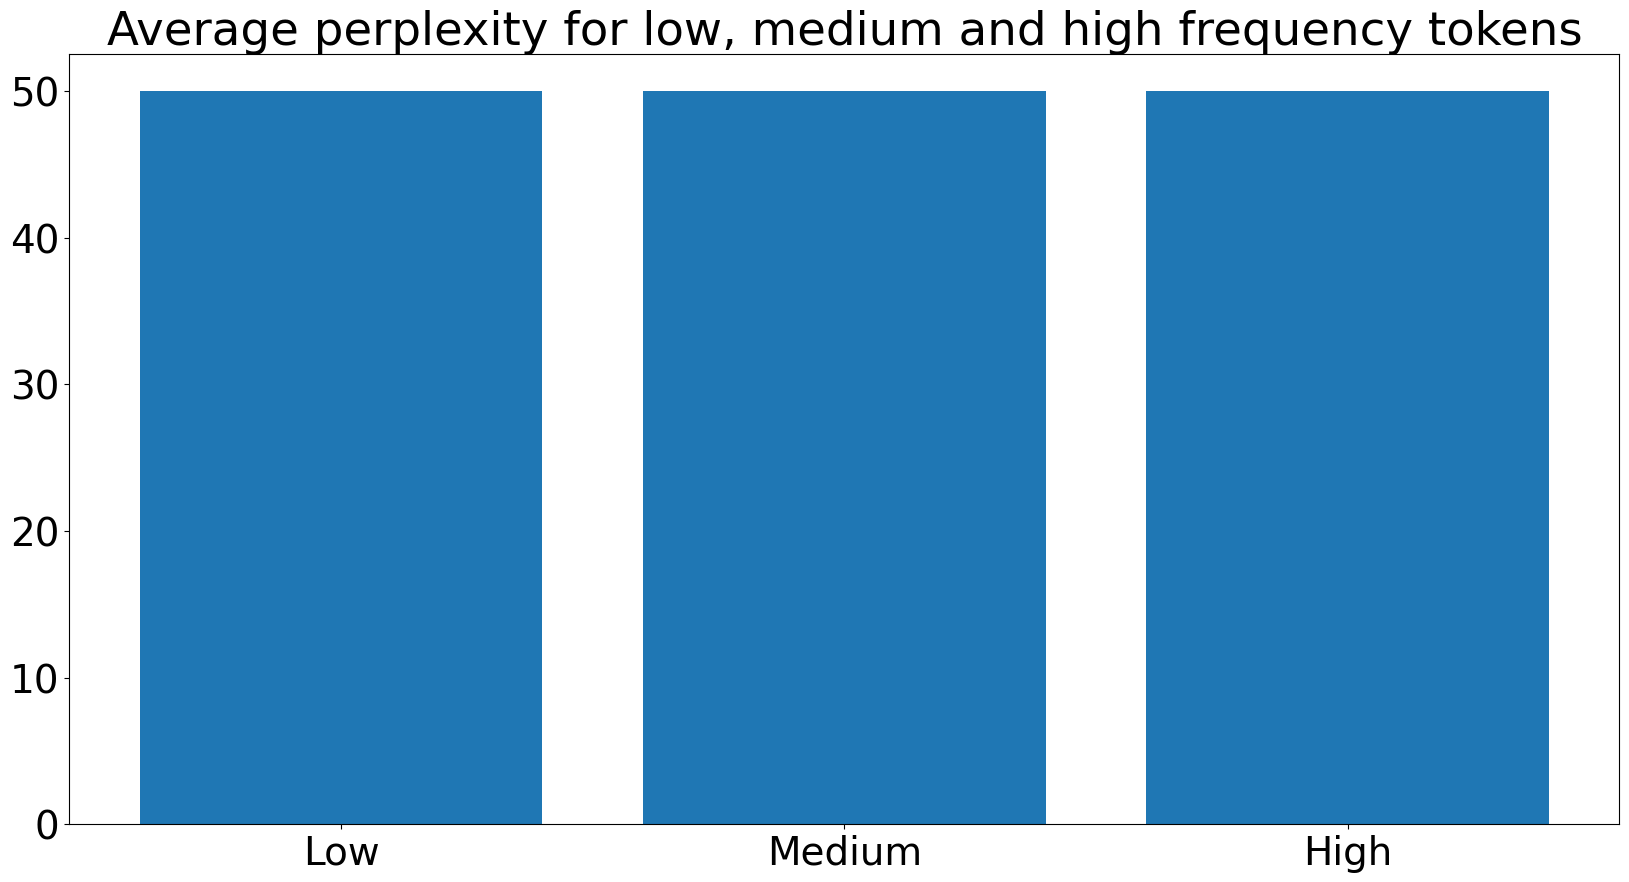

In [ ]:

plt.figure(figsize=(20, 10))
plt.bar(['Low', 'Medium', 'High'], [50, 50, 50])
plt.title('Average perplexity for low, medium and high frequency tokens')
plt.show()
